<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-analisis-tecnico/blob/main/ES_TA_Cap%C3%ADtulo_08_Optimizaci%C3%B3n_del_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# Optimización del Portfolio 
En esta sección aprenderemos el concepto de gestión de carteras.
La idea es combinar nuestras estrategias para reducir el riesgo de la inversión. Las nociones que estudiaremos se aplican tanto a las estrategias como a los activos. Podrás crear tu propia cartera utilizando los algoritmos que te presentaremos.

<br>

### Contenido
* Optimización de Sortino
* Optimización de la varianza mínima
* Optimización de la Meda, Varianza, Sesgo y Kurtosis

### Entorno

In [1]:
!pip install ta
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=820c7955a8bd56a8f878cef95f37beedf012d0c95c2245a1618bb092625b130a
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 37.5 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

In [2]:
import pandas as pd
import ta
import yfinance as yf

import seaborn as sns
from tqdm import tqdm
import numpy as np
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

### Funciones

In [4]:
def RSI(val, neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: La función da los rendimientos de la estrategia RSI                |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Valores de entrada de la acción      |
        |         -neutral (float): Valor neutral, es decir, zona de no acción       |
        |         -window (float): período de balanceo para el RSI                   |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("Necesitamos tener un nombre de columna Adj Close porque todos los cálculos se refieren a esta columna")
  
  val["rsi"] = ta.momentum.RSIIndicator(val["Adj Close"], window=window).rsi()


  
  """Señal de compra en largo """
  # Colocamos el umbral
  overbuy = 70
  neutral_buy = 50 + neutral

  # Poner valores nan para las columnas de la señal larga
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en largo (RSI ayer<55 y RSI hoy>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # Necesitamos definir la señal cierre en largo (RSI ayer>55 y RSI hoy<55) Señal falsa
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # Necesitamos definir la señal cierre en largo (RSI ayer<70 y RSI hoy>70) Señal de sobrecompra
  val.loc[(val["rsi"]>overbuy)&(val["yersteday_rsi"]<overbuy), "signal_long"] = 0



  """Señal de venta en corto """
  # Colocamos el umbral
  oversell = 30
  neutral_sell = 50 - neutral

  # Poner valores nan para las columnas de la señal larga
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en corto (RSI ayer>45 y RSI hoy<45)
  val.loc[(val["rsi"]<neutral_sell) & (val["yersteday_rsi"]>neutral_sell), "signal_short"] = -1

  # Necesitamos definir la señal de cierre en corto (RSI ayer<45 y RSI hoy>45) Señal falsa
  val.loc[(val["rsi"]>neutral_sell)&(val["yersteday_rsi"]<neutral_sell), "signal_short"] = 0

  # Necesitamos definir la señal de cierre en corto (RSI ayer>30 y RSI hoy<30) Señal de sobre venta
  val.loc[(val["rsi"]<oversell)&(val["yersteday_rsi"]>oversell), "signal_short"] = 0

  """Calcular el retorno """
  # Calculamos el porcentaje de variación del activo
  val["pct"] = val["Adj Close"].pct_change(1)

  # Calculamos las posiciones
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Calculamos el valor de retorno de la estrategia
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

In [5]:
def drawdown_function(serie):
  
  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1

  # We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

In [6]:
def BackTest(serie):

  # Import the benchmarcl
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  sp500.columns = ["SP500"]

  val = pd.concat((serie, sp500), axis=1).dropna()
  
  # Compute the drawdown
  drawdown = drawdown_function(serie)
  max_drawdown = -np.min(drawdown)

  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(15,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Put the cumsum
  cum.plot(serie.cumsum(), color="#39B3C7")
  cum.plot(val["Adj Close"].cumsum(), color="#B85A0F")
  cum.legend(["Portfolio", "SP500"])
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  # Plot the graph
  plt.show()

  # Compute the sortino
  sortino = np.sqrt(252)*serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val,rowvar=False)[0][1] /np.var(val["Adj Close"].dropna())

  # Compute the alpha
  alpha = 252*serie.mean() - 252*beta*serie.mean()

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha,3)}")
  print(f"MaxDrawdown: {np.round(max_drawdown*100,3)} %")


In [7]:
def opt(f):
  # Establecemos listas para los posibles valores de neutro y ventana
  neutral_values = [i*2 for i in range(10)]
  window_values = [i*2 for i in range(1,11)]

  # Definimos los valores límite de cada dataset
  start_train, end_train = "2017-01-01", "2019-01-01"
  start_test, end_test = "2019-01-01", "2020-01-01"
  start_valid, end_valid = "2020-01-01", "2021-01-01"


  # Inicializamos la lista
  resume = []

  # Bucle para añadir los valores de la lista
  for i in range(len(neutral_values)):
      for j in range(len(window_values)):
        # Calculamos los retornos
        return_train = RSI(f.loc[start_train:end_train], neutral_values[i], window_values[j])
        return_test = RSI(f.loc[start_test:end_test], neutral_values[i], window_values[j])

        # Calculamos el Ratio de Sortino
        sortino_train = np.sqrt(252) * return_train.mean() / return_train[return_train<0].std()
        sortino_test = np.sqrt(252) * return_test.mean() / return_test[return_test<0].std()

        # Creamos una lista de listas para construir el dataframe
        values = [neutral_values[i], window_values[j], sortino_train, sortino_test]
        resume.append(values)

  resume = pd.DataFrame(resume, columns=["Neutral", "Window", "Sortino Train", "Sortino Test"])

  # Ordenamos por Ratio de sortino
  ordered_resume = resume.sort_values(by="Sortino Train", ascending=False)



  for i in range(len(resume)):
    # Nos quedamos con el mejor
    best = ordered_resume.iloc[0+i:1+i,:]

    # Calculamos el Ratio de Sortino
    Strain = best["Sortino Train"].values[0]
    Stest = best["Sortino Test"].values[0]

    # Toma el mejor neutro y la mejor ventana
    best_neutral = best["Neutral"].values[0]
    best_window = best["Window"].values[0]

    # Si el Sortino del tren y la prueba son buenos detenemos el bucle
    if Stest>0.5 and Strain>0.5:
      break

    # Si no hay valores suficientemente buenos se pone 0 en todos los valores
    else:
      best_neutral = 0
      best_window = 0
      Strain = 0
      Stest = 0
  return [best_neutral, best_window, Strain, Stest]

# Sección 1: Optimización de Sortino

In [8]:
# Import Yahoo name
assets = pd.read_csv("/content/Names.csv")["Symbol"]

# Initialize the lists
resume = []
col = []

# Compute best parameters for each Asset
for fin in tqdm(assets):
  try:
    # Import the asset
    arr = yf.download(fin)

    # Put the values
    resume.append(opt(arr))
    col.append(fin)
  except:
    pass


  0%|          | 0/152 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  1%|          | 1/152 [00:04<10:20,  4.11s/it]

[*********************100%***********************]  1 of 1 completed


  1%|▏         | 2/152 [00:10<13:54,  5.57s/it]

[*********************100%***********************]  1 of 1 completed


  2%|▏         | 3/152 [00:17<15:43,  6.34s/it]

[*********************100%***********************]  1 of 1 completed


  3%|▎         | 4/152 [00:25<17:16,  7.00s/it]

[*********************100%***********************]  1 of 1 completed


  3%|▎         | 5/152 [00:30<15:23,  6.29s/it]

[*********************100%***********************]  1 of 1 completed


  4%|▍         | 6/152 [00:34<12:47,  5.26s/it]

[*********************100%***********************]  1 of 1 completed


  5%|▍         | 7/152 [00:37<11:12,  4.64s/it]

[*********************100%***********************]  1 of 1 completed


  5%|▌         | 8/152 [00:40<10:05,  4.20s/it]

[*********************100%***********************]  1 of 1 completed


  6%|▌         | 9/152 [00:44<09:16,  3.89s/it]

[*********************100%***********************]  1 of 1 completed


  7%|▋         | 10/152 [00:47<08:45,  3.70s/it]

[*********************100%***********************]  1 of 1 completed


  7%|▋         | 11/152 [00:50<08:23,  3.57s/it]

[*********************100%***********************]  1 of 1 completed


  8%|▊         | 12/152 [00:53<08:06,  3.48s/it]

[*********************100%***********************]  1 of 1 completed


  9%|▊         | 13/152 [00:57<07:53,  3.40s/it]

[*********************100%***********************]  1 of 1 completed


  9%|▉         | 14/152 [01:00<07:45,  3.37s/it]

[*********************100%***********************]  1 of 1 completed


 10%|▉         | 15/152 [01:03<07:36,  3.33s/it]

[*********************100%***********************]  1 of 1 completed


 11%|█         | 16/152 [01:06<07:29,  3.30s/it]

[*********************100%***********************]  1 of 1 completed


 11%|█         | 17/152 [01:10<07:23,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 12%|█▏        | 18/152 [01:13<07:19,  3.28s/it]

[*********************100%***********************]  1 of 1 completed


 12%|█▎        | 19/152 [01:16<07:13,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 13%|█▎        | 20/152 [01:19<07:08,  3.24s/it]

[*********************100%***********************]  1 of 1 completed


 14%|█▍        | 21/152 [01:23<07:05,  3.25s/it]

[*********************100%***********************]  1 of 1 completed


 14%|█▍        | 22/152 [01:26<06:59,  3.23s/it]

[*********************100%***********************]  1 of 1 completed


 15%|█▌        | 23/152 [01:29<06:59,  3.25s/it]

[*********************100%***********************]  1 of 1 completed


 16%|█▌        | 24/152 [01:32<06:52,  3.23s/it]

[*********************100%***********************]  1 of 1 completed


 16%|█▋        | 25/152 [01:35<06:48,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 17%|█▋        | 26/152 [01:39<06:42,  3.20s/it]

[*********************100%***********************]  1 of 1 completed


 18%|█▊        | 27/152 [01:42<06:40,  3.20s/it]

[*********************100%***********************]  1 of 1 completed


 18%|█▊        | 28/152 [01:45<06:38,  3.21s/it]

[*********************100%***********************]  1 of 1 completed


 19%|█▉        | 29/152 [01:48<06:32,  3.19s/it]

[*********************100%***********************]  1 of 1 completed


 20%|█▉        | 30/152 [01:53<07:14,  3.57s/it]

[*********************100%***********************]  1 of 1 completed


 20%|██        | 31/152 [01:56<07:14,  3.59s/it]

[*********************100%***********************]  1 of 1 completed


 21%|██        | 32/152 [01:59<06:55,  3.46s/it]

[*********************100%***********************]  1 of 1 completed


 22%|██▏       | 33/152 [02:02<06:36,  3.33s/it]

[*********************100%***********************]  1 of 1 completed


 22%|██▏       | 34/152 [02:05<06:19,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 23%|██▎       | 35/152 [02:09<06:16,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 24%|██▎       | 36/152 [02:12<06:10,  3.20s/it]

[*********************100%***********************]  1 of 1 completed


 24%|██▍       | 37/152 [02:15<06:07,  3.19s/it]

[*********************100%***********************]  1 of 1 completed


 25%|██▌       | 38/152 [02:18<06:06,  3.21s/it]

[*********************100%***********************]  1 of 1 completed


 26%|██▌       | 39/152 [02:22<06:05,  3.24s/it]

[*********************100%***********************]  1 of 1 completed


 26%|██▋       | 40/152 [02:25<06:00,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 27%|██▋       | 41/152 [02:28<05:57,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 28%|██▊       | 42/152 [02:31<05:54,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 28%|██▊       | 43/152 [02:34<05:51,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 29%|██▉       | 44/152 [02:37<05:43,  3.18s/it]

[*********************100%***********************]  1 of 1 completed


 30%|██▉       | 45/152 [02:41<05:42,  3.20s/it]

[*********************100%***********************]  1 of 1 completed


 30%|███       | 46/152 [02:44<05:38,  3.19s/it]

[*********************100%***********************]  1 of 1 completed


 31%|███       | 47/152 [02:47<05:35,  3.20s/it]

[*********************100%***********************]  1 of 1 completed


 32%|███▏      | 48/152 [02:50<05:31,  3.18s/it]

[*********************100%***********************]  1 of 1 completed


 32%|███▏      | 49/152 [02:53<05:28,  3.19s/it]

[*********************100%***********************]  1 of 1 completed


 33%|███▎      | 50/152 [02:57<05:25,  3.19s/it]

[*********************100%***********************]  1 of 1 completed


 34%|███▎      | 51/152 [03:00<05:27,  3.24s/it]

[*********************100%***********************]  1 of 1 completed


 34%|███▍      | 52/152 [03:03<05:25,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 35%|███▍      | 53/152 [03:07<05:23,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 36%|███▌      | 54/152 [03:10<05:19,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 36%|███▌      | 55/152 [03:13<05:14,  3.25s/it]

[*********************100%***********************]  1 of 1 completed


 37%|███▋      | 56/152 [03:16<05:09,  3.23s/it]

[*********************100%***********************]  1 of 1 completed


 38%|███▊      | 57/152 [03:19<05:05,  3.21s/it]

[*********************100%***********************]  1 of 1 completed


 38%|███▊      | 58/152 [03:23<05:02,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 39%|███▉      | 59/152 [03:26<04:58,  3.21s/it]

[*********************100%***********************]  1 of 1 completed


 39%|███▉      | 60/152 [03:29<05:00,  3.27s/it]

[*********************100%***********************]  1 of 1 completed


 40%|████      | 61/152 [03:33<04:58,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 41%|████      | 62/152 [03:36<04:55,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 41%|████▏     | 63/152 [03:39<04:52,  3.28s/it]

[*********************100%***********************]  1 of 1 completed


 42%|████▏     | 64/152 [03:42<04:47,  3.27s/it]

[*********************100%***********************]  1 of 1 completed


 43%|████▎     | 65/152 [03:46<04:49,  3.33s/it]

[*********************100%***********************]  1 of 1 completed


 43%|████▎     | 66/152 [03:49<04:42,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 44%|████▍     | 67/152 [03:52<04:41,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 45%|████▍     | 68/152 [03:56<04:36,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 45%|████▌     | 69/152 [03:59<04:32,  3.28s/it]

[*********************100%***********************]  1 of 1 completed


 46%|████▌     | 70/152 [04:02<04:29,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 47%|████▋     | 71/152 [04:06<04:27,  3.30s/it]

[*********************100%***********************]  1 of 1 completed


 47%|████▋     | 72/152 [04:09<04:25,  3.32s/it]

[*********************100%***********************]  1 of 1 completed


 48%|████▊     | 73/152 [04:12<04:23,  3.34s/it]

[*********************100%***********************]  1 of 1 completed


 49%|████▊     | 74/152 [04:15<04:18,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 49%|████▉     | 75/152 [04:19<04:13,  3.30s/it]

[*********************100%***********************]  1 of 1 completed


 50%|█████     | 76/152 [04:22<04:11,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 51%|█████     | 77/152 [04:25<04:08,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 51%|█████▏    | 78/152 [04:29<04:04,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 52%|█████▏    | 79/152 [04:32<04:01,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 53%|█████▎    | 80/152 [04:35<03:57,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 53%|█████▎    | 81/152 [04:39<03:54,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 54%|█████▍    | 82/152 [04:42<03:52,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 55%|█████▍    | 83/152 [04:45<03:48,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 55%|█████▌    | 84/152 [04:49<03:46,  3.32s/it]

[*********************100%***********************]  1 of 1 completed


 56%|█████▌    | 85/152 [04:52<03:38,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 57%|█████▋    | 86/152 [04:55<03:34,  3.24s/it]

[*********************100%***********************]  1 of 1 completed


 57%|█████▋    | 87/152 [04:58<03:32,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 58%|█████▊    | 88/152 [05:02<03:30,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 59%|█████▊    | 89/152 [05:05<03:25,  3.25s/it]

[*********************100%***********************]  1 of 1 completed


 59%|█████▉    | 90/152 [05:08<03:23,  3.28s/it]

[*********************100%***********************]  1 of 1 completed


 60%|█████▉    | 91/152 [05:11<03:19,  3.27s/it]

[*********************100%***********************]  1 of 1 completed


 61%|██████    | 92/152 [05:15<03:15,  3.27s/it]

[*********************100%***********************]  1 of 1 completed


 61%|██████    | 93/152 [05:18<03:13,  3.28s/it]

[*********************100%***********************]  1 of 1 completed


 62%|██████▏   | 94/152 [05:21<03:09,  3.27s/it]

[*********************100%***********************]  1 of 1 completed


 62%|██████▎   | 95/152 [05:24<03:06,  3.27s/it]

[*********************100%***********************]  1 of 1 completed


 63%|██████▎   | 96/152 [05:28<03:05,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 64%|██████▍   | 97/152 [05:31<02:59,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 64%|██████▍   | 98/152 [05:34<02:54,  3.23s/it]

[*********************100%***********************]  1 of 1 completed


 65%|██████▌   | 99/152 [05:37<02:51,  3.24s/it]

[*********************100%***********************]  1 of 1 completed


 66%|██████▌   | 100/152 [05:41<02:47,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 66%|██████▋   | 101/152 [05:44<02:45,  3.24s/it]

[*********************100%***********************]  1 of 1 completed


 67%|██████▋   | 102/152 [05:47<02:42,  3.24s/it]

[*********************100%***********************]  1 of 1 completed


 68%|██████▊   | 103/152 [05:50<02:39,  3.25s/it]

[*********************100%***********************]  1 of 1 completed


 68%|██████▊   | 104/152 [05:54<02:35,  3.25s/it]

[*********************100%***********************]  1 of 1 completed


 69%|██████▉   | 105/152 [05:57<02:35,  3.30s/it]

[*********************100%***********************]  1 of 1 completed


 70%|██████▉   | 106/152 [06:00<02:29,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 70%|███████   | 107/152 [06:03<02:26,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 71%|███████   | 108/152 [06:07<02:23,  3.26s/it]

[*********************100%***********************]  1 of 1 completed


 72%|███████▏  | 109/152 [06:10<02:22,  3.32s/it]

[*********************100%***********************]  1 of 1 completed


 72%|███████▏  | 110/152 [06:13<02:19,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 73%|███████▎  | 111/152 [06:17<02:16,  3.34s/it]

[*********************100%***********************]  1 of 1 completed


 74%|███████▎  | 112/152 [06:20<02:12,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 74%|███████▍  | 113/152 [06:23<02:08,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 75%|███████▌  | 114/152 [06:27<02:04,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 76%|███████▌  | 115/152 [06:30<02:01,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 76%|███████▋  | 116/152 [06:33<01:58,  3.30s/it]

[*********************100%***********************]  1 of 1 completed


 77%|███████▋  | 117/152 [06:37<01:55,  3.30s/it]

[*********************100%***********************]  1 of 1 completed


 78%|███████▊  | 118/152 [06:40<01:52,  3.31s/it]

[*********************100%***********************]  1 of 1 completed


 78%|███████▊  | 119/152 [06:43<01:47,  3.27s/it]

[*********************100%***********************]  1 of 1 completed


 79%|███████▉  | 120/152 [06:46<01:44,  3.28s/it]

[*********************100%***********************]  1 of 1 completed


 80%|███████▉  | 121/152 [06:50<01:40,  3.23s/it]

[*********************100%***********************]  1 of 1 completed


 80%|████████  | 122/152 [06:53<01:38,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 81%|████████  | 123/152 [06:56<01:35,  3.30s/it]

[*********************100%***********************]  1 of 1 completed


 82%|████████▏ | 124/152 [07:00<01:32,  3.29s/it]

[*********************100%***********************]  1 of 1 completed


 82%|████████▏ | 125/152 [07:03<01:28,  3.27s/it]

[*********************100%***********************]  1 of 1 completed


 83%|████████▎ | 126/152 [07:06<01:25,  3.30s/it]

[*********************100%***********************]  1 of 1 completed


 84%|████████▎ | 127/152 [07:09<01:22,  3.29s/it]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ALXN: No data found, symbol may be delisted


 84%|████████▍ | 128/152 [07:12<01:13,  3.07s/it]

[*********************100%***********************]  1 of 1 completed


 85%|████████▍ | 129/152 [07:15<01:12,  3.16s/it]

[*********************100%***********************]  1 of 1 completed


 86%|████████▌ | 130/152 [07:19<01:09,  3.17s/it]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- XLNX: No data found, symbol may be delisted


 86%|████████▌ | 131/152 [07:21<01:02,  2.98s/it]

[*********************100%***********************]  1 of 1 completed


 87%|████████▋ | 132/152 [07:24<01:01,  3.08s/it]

[*********************100%***********************]  1 of 1 completed


 88%|████████▊ | 133/152 [07:28<00:59,  3.14s/it]

[*********************100%***********************]  1 of 1 completed


 88%|████████▊ | 134/152 [07:31<00:56,  3.12s/it]

[*********************100%***********************]  1 of 1 completed


 89%|████████▉ | 135/152 [07:34<00:53,  3.14s/it]

[*********************100%***********************]  1 of 1 completed


 89%|████████▉ | 136/152 [07:40<01:05,  4.10s/it]

[*********************100%***********************]  1 of 1 completed


 90%|█████████ | 137/152 [07:44<01:00,  4.03s/it]

[*********************100%***********************]  1 of 1 completed


 91%|█████████ | 138/152 [07:47<00:52,  3.76s/it]

[*********************100%***********************]  1 of 1 completed


 91%|█████████▏| 139/152 [07:50<00:46,  3.61s/it]

[*********************100%***********************]  1 of 1 completed


 92%|█████████▏| 140/152 [07:54<00:41,  3.50s/it]

[*********************100%***********************]  1 of 1 completed


 93%|█████████▎| 141/152 [07:57<00:37,  3.40s/it]

[*********************100%***********************]  1 of 1 completed


 93%|█████████▎| 142/152 [08:00<00:33,  3.36s/it]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MXIM: No data found, symbol may be delisted


 94%|█████████▍| 143/152 [08:03<00:28,  3.13s/it]

[*********************100%***********************]  1 of 1 completed


 95%|█████████▍| 144/152 [08:06<00:25,  3.16s/it]

[*********************100%***********************]  1 of 1 completed


 95%|█████████▌| 145/152 [08:09<00:22,  3.17s/it]

[*********************100%***********************]  1 of 1 completed


 96%|█████████▌| 146/152 [08:12<00:19,  3.18s/it]

[*********************100%***********************]  1 of 1 completed


 97%|█████████▋| 147/152 [08:16<00:16,  3.20s/it]

[*********************100%***********************]  1 of 1 completed


 97%|█████████▋| 148/152 [08:19<00:12,  3.21s/it]

[*********************100%***********************]  1 of 1 completed


 98%|█████████▊| 149/152 [08:22<00:09,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 99%|█████████▊| 150/152 [08:25<00:06,  3.22s/it]

[*********************100%***********************]  1 of 1 completed


 99%|█████████▉| 151/152 [08:28<00:03,  3.20s/it]

[*********************100%***********************]  1 of 1 completed


100%|██████████| 152/152 [08:32<00:00,  3.37s/it]


In [10]:
# Add asset columns to each list of resume
for i in range(len(resume)):
  resume[i].append(col[i])

# Create a dataframe
res = pd.DataFrame(resume, columns=["Neutral", "Window", "Train", "Test", "Asset"])

# Indexig by asset
res = res.set_index("Asset")
res

,Neutral,Window,Train,Test
Asset,,,,
EURUSD=X,0,0,0.00000,0.000000
EURGBP=X,0,0,0.00000,0.000000
EURCHF=X,0,0,0.00000,0.000000
EURCAD=X,0,0,0.00000,0.000000
EURCNY=X,0,0,0.00000,0.000000
...,...,...,...,...
TCOM,18,10,2.14346,2.113103
INCY,0,0,0.00000,0.000000
CHKP,0,0,0.00000,0.000000


In [11]:
# Order the dataframe using the Train sortino
values = res.sort_values(by="Train", ascending=False)
values.head(20)

,Neutral,Window,Train,Test
Asset,,,,
BSV-USD,4,2,9.513393,1.325473
MU,16,16,5.946537,0.801210
NZDUSD=X,18,12,4.010322,1.327504
USDMYR=X,8,18,3.478817,3.094099
XRP-USD,2,10,3.291606,1.151095
DOGE-USD,2,12,3.246218,0.945126
ADA-USD,2,20,3.176791,0.652133
BCH-USD,18,10,2.901775,2.980893
KHC,18,12,2.559434,5.485875


In [12]:
# Border of sets
start_train, end_train = "2017-01-01", "2019-01-01"
start_test, end_test = "2019-01-01", "2020-01-01"
start_valid, end_valid = "2020-01-01", "2021-01-01"

# Create a dataframe to put the strategies (The assets of the portfolio)
strategies = pd.DataFrame()
for col in values.index[0:15]:
  
  # Import the asset
  l = yf.download(col)

  # Extract opptimal neutral
  best_neutral = values.loc[col]["Neutral"]

  # Exctract optimal window
  best_window = values.loc[col]["Window"]
  
  strategies[f"{col}"] = RSI(l.loc[start_train:],best_neutral,int(best_window))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [14]:
strategies.dropna()

,BSV-USD,MU,NZDUSD=X,USDMYR=X,XRP-USD,DOGE-USD,ADA-USD,BCH-USD,KHC,VET-USD,LRCX,EBAY,MIOTA-USD,NEO-USD,XLM-USD
Date,,,,,,,,,,,,,,,
2018-11-16,0.0,-0.0,0.004764,-0.001073,0.020965,-0.000000,0.037644,-0.0,0.0,-0.000000,0.0,-0.000000,0.023106,-0.000000,-0.000000
2018-11-19,-0.0,-0.0,0.000000,0.000119,-0.063288,-0.000000,0.150753,-0.0,-0.0,-0.000000,-0.0,-0.000000,0.138887,-0.000000,-0.000000
2018-11-20,-0.0,-0.0,-0.000000,-0.000716,0.090847,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.0,0.000000,-0.000000,-0.000000,0.139115
2018-11-21,0.0,0.0,-0.000000,0.000358,-0.029731,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.054324
2018-11-23,0.0,0.0,-0.000000,0.000000,0.043776,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.0,0.000000,0.000000,0.000000,0.035070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,-0.0,-0.0,-0.000000,-0.000000,-0.061084,-0.000000,-0.073108,-0.0,0.0,-0.000000,-0.0,-0.000000,-0.086674,-0.000000,-0.000000
2022-07-26,0.0,-0.0,0.000000,0.000000,-0.001485,-0.003306,-0.000000,-0.0,0.0,0.002011,-0.0,-0.000000,0.002017,0.000513,0.006912
2022-07-27,0.0,0.0,-0.000000,0.000000,-0.063058,-0.072130,-0.091842,0.0,-0.0,-0.079225,0.0,0.000000,-0.078902,-0.083162,-0.066385


In [ ]:
strategies = strategies.iloc[:,1:]

In [16]:
def SR_criterion(weight, returns):
  """ 
  ------------------------------------------------------------------------------
  | Output: El opuesto del Ratio de Sortino para hacer una minimización        |
  ------------------------------------------------------------------------------
  | Inputs: -Weight (type ndarray numpy): Pesos de  activo para el portfolio   |
  |         -returns (type dataframe pandas): Retorno del activo               |
  ------------------------------------------------------------------------------
  """
  pf_return = returns.values.dot(weight)
  mu = np.mean(pf_return) 
  sigma = np.std(pf_return[pf_return<0])
  Sortino = -mu/sigma
  return Sortino




n=len(strategies.transpose())

# Inicializamos los pesos
x0 = np.zeros(n)+(1/n)

# Restricciones del problema de optimización
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

Bounds= [(0 , 1) for i in range(0,n)]


# Resolución de un problema de optimización
res_SR = minimize(SR_criterion, x0, method="SLSQP", args=(strategies.loc[start_train:end_test].dropna()),bounds=Bounds,constraints=cons,options={'disp': False})

# Result for visualization
print(res_SR)

# Result for computations
X = res_SR.x


     fun: -0.4067533229486335
     jac: array([-1.23900555e-01, -7.15334564e-02, -4.53913957e-03, -2.19799019e-02,
        2.21000217e-01,  2.57696137e-02,  6.01797748e-01, -4.43943366e-02,
       -4.42025438e-02,  5.07708777e+04, -5.50171472e-02, -5.13990670e-02,
        5.07706198e+04,  6.07793245e-01,  1.41144186e-01])
 message: 'Positive directional derivative for linesearch'
    nfev: 58
     nit: 7
    njev: 3
  status: 8
 success: False
       x: array([3.61639981e-01, 4.15575589e-02, 1.54776641e-05, 2.64866022e-03,
       9.76252227e-04, 2.05519181e-01, 2.07963594e-16, 2.20092487e-02,
       1.94529920e-02, 0.00000000e+00, 1.53066011e-02, 8.96724446e-03,
       4.15927188e-17, 1.54766787e-05, 3.22061580e-01])


In [17]:
np.round(X, 3)

array([0.362, 0.042, 0.   , 0.003, 0.001, 0.206, 0.   , 0.022, 0.019,
       0.   , 0.015, 0.009, 0.   , 0.   , 0.322])

[*********************100%***********************]  1 of 1 completed


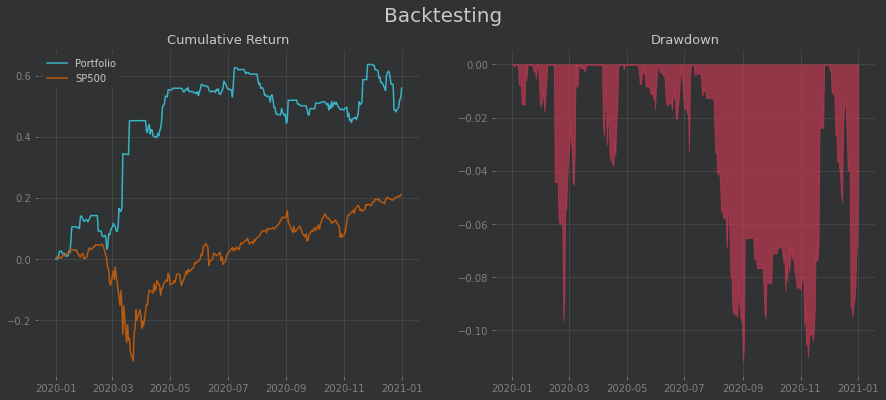

Sortino: 2.348
Beta: -0.163
Alpha: 0.446
MaxDrawdown: 11.166 %


In [18]:
# BackTest Sortino Optimization
sr = np.multiply(strategies.loc[start_valid:end_valid], X).sum(axis=1)
BackTest(sr)

# Sección 2: Optimización de la varianza mínima


In [19]:
def MV_criterion(weight,Returns_data):
  """ 
  ------------------------------------------------------------------------------
  | Output: Criterio de Optimización de la Cartera                             |
  ------------------------------------------------------------------------------
  | Inputs: -weight (type ndarray numpy): Pesos del portfolio.                 |
  |         -Returns_data (type ndarray numpy): Retorno de Activos             |
  ------------------------------------------------------------------------------
  """
  portfolio_return=np.multiply(Returns_data,np.transpose(weight));
  portfolio_return=np.sum(portfolio_return,1);
  mean_ret=np.mean(portfolio_return,0)
  sd_ret=np.std(portfolio_return,0)
  criterion = sd_ret
  return criterion




n=len(strategies.transpose())
# Inicializamos los pesos
x0 = np.zeros(n)+(1/n)

# Restricciones del problema de optimización
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

Bounds= [(0 , 1) for i in range(0,n)]


# Resolución de un problema de optimización
res_MV = minimize(MV_criterion, x0, method="SLSQP", args=(strategies.loc[start_train:end_test].dropna()),bounds=Bounds,constraints=cons,options={'disp': False})

# Result for visualization
print(res_MV)

# Result for computations
X = res_MV.x

     fun: 0.0006182958449400477
     jac: array([0.00173774, 0.00057293, 0.00036833, 0.00083233, 0.00041571,
       0.00062749, 0.00287312, 0.00102705, 0.00036724, 0.00116461,
       0.00035069, 0.00085802, 0.00064413, 0.00071483, 0.00261521])
 message: 'Optimization terminated successfully'
    nfev: 385
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([0.00000000e+00, 9.13246907e-03, 4.16188440e-01, 3.63102562e-01,
       1.46303877e-03, 3.38497282e-04, 0.00000000e+00, 3.03918531e-02,
       1.10962132e-02, 7.25347555e-19, 4.61553161e-02, 1.22131611e-01,
       0.00000000e+00, 1.94564757e-19, 2.05156391e-19])


In [23]:
print(np.round(res_SR.x, 3))
print(np.round(res_MV.x, 3))

[0.362 0.042 0.    0.003 0.001 0.206 0.    0.022 0.019 0.    0.015 0.009
 0.    0.    0.322]
[0.    0.009 0.416 0.363 0.001 0.    0.    0.03  0.011 0.    0.046 0.122
 0.    0.    0.   ]


[*********************100%***********************]  1 of 1 completed


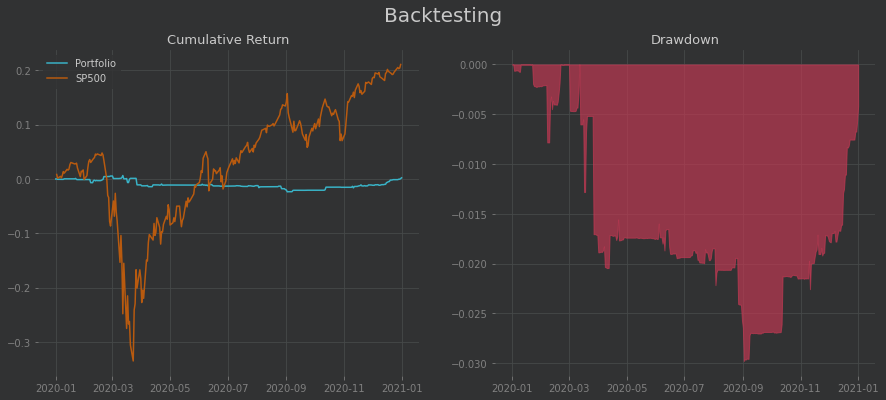

Sortino: 0.062
Beta: -0.015
Alpha: 0.001
MaxDrawdown: 2.977 %


In [24]:
# BackTest MinVar Optimization
mv = np.multiply(strategies.loc[start_valid:end_valid], X).sum(axis=1)
BackTest(mv)

# Sección 3: Optimización de Media, Varianza, Sesgo y Curtosis

In [25]:
def SK_criterion(weight,Returns_data):
  """ 
  ------------------------------------------------------------------------------
  | Output: Criterio de Optimización de Portfolio                              |
  ------------------------------------------------------------------------------
  | Inputs: -weight (type ndarray numpy): Pesos del portfolio.                 |
  |         -Returns_data (type ndarray numpy): Retorno de Activos             |
  ------------------------------------------------------------------------------
  """
  from scipy.stats import skew, kurtosis

  Lambda_RA = 3
  portfolio_return=np.multiply(Returns_data,np.transpose(weight));
  portfolio_return=np.sum(portfolio_return,1);
  mean_ret=np.mean(portfolio_return,0)
  sd_ret=np.std(portfolio_return,0)
  skew_ret=skew(portfolio_return,0)
  kurt_ret=kurtosis(portfolio_return,0)
  W=1;
  Wbar=1*(1+0.25/100);
  criterion=np.power(Wbar,1-Lambda_RA)/(1+Lambda_RA)+np.power(Wbar,-Lambda_RA)*W*mean_ret-Lambda_RA/2*np.power(Wbar,-1-Lambda_RA)*np.power(W,2)*np.power(sd_ret,2)+Lambda_RA*(Lambda_RA+1)/(6)*np.power(Wbar,-2-Lambda_RA)*np.power(W,3)*skew_ret-Lambda_RA*(Lambda_RA+1)*(Lambda_RA+2)/(24)*np.power(Wbar,-3-Lambda_RA)*np.power(W,4)*kurt_ret
  criterion=-criterion;
  return criterion



n=len(strategies.transpose())
# Inicialización de los pesos
x0 = np.zeros(n)+(1/n)

# Restricciones del problema de Optimización
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

Bounds= [(0 , 1) for i in range(0,n)]


# Resolver el problema de optimización
res_SK = minimize(SK_criterion, x0, method="SLSQP", args=(strategies.loc[start_train:end_test].dropna()),bounds=Bounds,constraints=cons,options={'disp': False})

# Result for visualization
print(res_SK)

# Result for computations
X = res_SK.x


     fun: 8.068332519718107
     jac: array([ 5.45901554e+01, -5.77330589e-04,  2.25887895e-01,  3.73845696e-01,
       -3.01921368e-03, -1.13439560e-03,  2.89127768e+01, -1.13058090e-03,
       -6.29663467e-04,  1.16320611e+01,  7.52385855e-02,  7.77286291e-02,
       -2.46644020e-04,  3.17098749e+00,  3.51406432e+01])
 message: 'Optimization terminated successfully'
    nfev: 518
     nit: 31
    njev: 31
  status: 0
 success: True
       x: array([1.55432156e-11, 2.95099275e-01, 0.00000000e+00, 0.00000000e+00,
       2.80449642e-02, 8.58336504e-02, 1.04653710e-11, 1.07400627e-01,
       3.39881150e-01, 2.22385836e-14, 9.73302932e-13, 4.23282670e-12,
       1.43740333e-01, 0.00000000e+00, 8.84859495e-12])


In [26]:
(pd.DataFrame([res_SR.x, res_MV.x, res_SK.x], columns=strategies.columns, index = ["SK", "SR", "MV"])*100).round(1)

,BSV-USD,MU,NZDUSD=X,USDMYR=X,XRP-USD,DOGE-USD,ADA-USD,BCH-USD,KHC,VET-USD,LRCX,EBAY,MIOTA-USD,NEO-USD,XLM-USD
SK,36.2,4.2,0.0,0.3,0.1,20.6,0.0,2.2,1.9,0.0,1.5,0.9,0.0,0.0,32.2
SR,0.0,0.9,41.6,36.3,0.1,0.0,0.0,3.0,1.1,0.0,4.6,12.2,0.0,0.0,0.0
MV,0.0,29.5,0.0,0.0,2.8,8.6,0.0,10.7,34.0,0.0,0.0,0.0,14.4,0.0,0.0


[*********************100%***********************]  1 of 1 completed


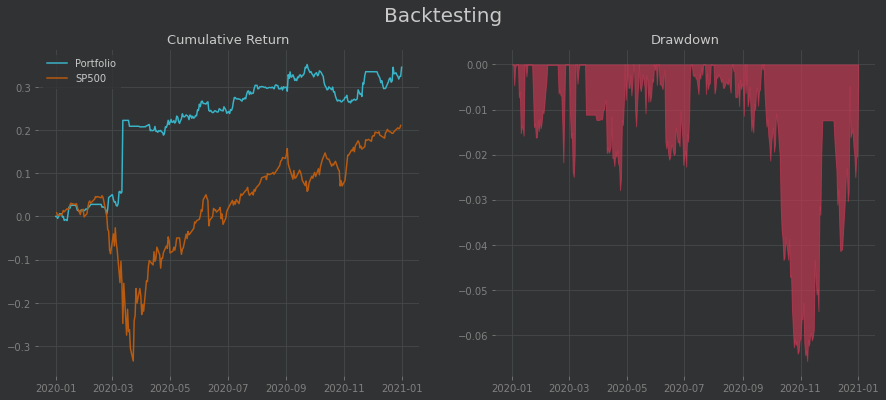

Sortino: 3.959
Beta: -0.141
Alpha: 0.27
MaxDrawdown: 6.578 %


In [27]:
# Plot the performances
s = np.multiply(strategies.loc[start_valid:end_valid], X).sum(axis=1)
BackTest(s)